In [1]:
version = "2.1.2"

<a id='toc'></a>
# Table of Contents
- **[Assignment Description](#Topic0)**
- **[Topic 1 - K-means clustering on text documents](#Topic1)**
  - [Task 1](#t1)
- **[Topic 2 - Cluster Labeling](#Topic2)**
  - [Task 2](#t2)
- **[Topic 3 - Hierarchical clustering](#Topic3)**
  - [Task 3](#t3)
- **[Topic 4 - Clustering, Feature Types, and Representations](#Topic4)**
  - [Task 4a](#t4a)
  - [Task 4b](#t4b)

In [2]:
# Suppress all warnings only when absolutely necessary
# Warnings are in place for a reason!
import warnings

# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

<a id='Topic0'></a>
## SIADS 543 Assignment 2: Clustering

In this week's assignment you'll gain experience applying different clustering methods, computing cluster labels, and selecting an optimal number of clusters based on quality assessment metrics. In addition, you'll gain experience working with text data. 

We'll continue to use the "beer" dataset, but this time focused more on the *text* of beer reviews. In the "bag of words" scenario, each review is represented by a sparse vector that's filled in according to which specific terms are found in that review. (As a reminder, we generally use "term" to refer to a word or phrase that's part of a text representation - since as you'll see below, when working with text it's very useful to work with phrases as features as well as individual words.) In particular, we'll treat single terms and two-term bigrams (phrases) as features here. You'll apply a simple Vectorizer to process the text, which will also be a useful prelude to next week's upcoming assignment on topic models. To familiarize yourself with how a text passage can be represented as a vector of word counts or weights, the "bag of words" model, *please read Sec. 7.3-7.5 in the textbook*. 

As usual, please read through the entire assignment before starting, to get an idea of how the questions relate to each other and the overall goals.

*Please note that for autograder messages that check a list, it will report any problems using a list index starting at zero, i.e. the first list element is called "element 0".*  

<a href='#toc'>TOC</a>

In [3]:
# First import some necessary libararies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

up, down = True, False

In [4]:
np.set_printoptions(precision=3)

## Additional imports can be inlcuded here

<a id='Topic1'></a>
### Topic 1 - K-means clustering on text documents

In this question you'll apply k-means clustering to a set of text documents to gain some insight into the nature of the content. We're going to use the same beer dataset as last week, but this time we'll focus on the 'text' column that contains written reviews of the tasty beverage.

This scenario uses the TfidfVectorizer class (described in Sec. 7.5), to convert each textual review to a numeric vector. We're going to cover text processing in more detail next week, including TfidfVectorizer and its many parameters, but for now we've provided you the code that reads in the dataset, and converts each text review into a sparse numeric vector. 

A general rule when clustering text documents is that *noun phrases* work well as features. For now, we'll ignore parts of speech, but we will use both single words and *bigrams* (two-word phrases) as features. This is easy to do with the Vectorizer by setting the ngram_range property to (1,2).  

A big problem in applying $K$-means (and many other unsupervised clustering-type methods) is that we need to specify the number of clusters $K$ in advance - but we don't know in advance what value of $K$ will give the best-quality clustering!  So, to pick the "best" number of clusters we're going to rely on calculating some automated measures of cluster quality. You'll compute these cluster quality measures for each choice of $K$, and then pick the value of $K$ that gives the best value of the quality measure(s).

We seen a few ways to assess cluster quality, including the silhouette score, but we're going to try out two alternative cluster quality measures that you should be aware of. They reward different ideas of "quality" for a clustering, but like the silhouette score, do not require ground-truth labels to compute quality (which is good, because we don't have them). These two measures are:

The Davies-Bouldin score https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html 
*Lower* is better for the Davies-Bouldin score.

The Calinski-Harabasz index  https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index
*Higher* is better for the Calinski-Harabasz index.

We're looking for clusterings that have a *high* Calinski-Harabasz index, but a *low* Davies-Bouldin score.  

<a href='#toc'>TOC</a>

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# This function returns:
# - a matrix X with one row per document (review). Each row is a sparse
# vector containing tf.idf term weights for the words in the document.
#
# - the vectorizor used to create X
#
# - the actual reviews used as input to the vectorizer


def get_beer_reviews_vectorized(top_n=-1, ngram_range=(1, 1), max_features=1000):
    df = pd.read_csv("./assets/beer2.csv")["text"]
    df = df.dropna()  # drop any rows with empty reviews
    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=max_features,
        min_df=2,
        stop_words="english",
        ngram_range=ngram_range,
        use_idf=True,
    )
    if top_n >= 0:
        review_instances = df.values[0:top_n]
    else:
        review_instances = df.values

    X = vectorizer.fit_transform(review_instances)

    return (X, vectorizer, review_instances)


def print_cluster_features(vectorizer, centroids, n_clusters, top_n_features):
    terms = vectorizer.get_feature_names()
    for i in range(n_clusters):
        print("Cluster %d:" % i, end="")
        for ind in centroids[i, :top_n_features]:
            print(" [%s]" % terms[ind], end="")
        print()

### Execute the following cell to preprocess the dataset.
 - For efficiency reasons we're going to sample a subset of reviews
 - For performance reasons, this question will use only the first 5000 reviews in the dataset.

In [6]:
(X, vectorizer, review_instances) = get_beer_reviews_vectorized(5000, (1, 2))

<a id='t1'></a>
### Task 1 - K-means Review  (25 points)

Okay - here's what you need to do for Question 1:

1. Get the vectorized reviews using the get_beer_reviews_vectorized() function as shown below. For speed reasons we will only analyze a sample of 5000 reviews and not the whole set. The vectorized reviews will be output to the matrix X, which should have 5000 rows (one per review) and 1000 columns (one per word/term in the vocabulary produced by the vectorizer).

2. For each choice of K from 2 to 9, run k-means clustering on these reviews. For each K, compute the above two cluster quality scores on the resulting clustering. IMPORTANT: You won't be including the code to run the whole loop in your autograded code submission: you're just trying to find the optimal value for $K$ for now.

IMPORTANT: *when running KMeans, set init='k-means++', max_iter=100, n_init=1, and random_state=42.*

After you perform your clustering run in Step 2, you should see there's one clearly superior choice for K that gives the best value for both metrics (high Calinski-Harabasz score, low Davies-Bouldin score). 

3. Now you will write your assignment code that does a single clustering using that optimal K, and finds what the predominant terms are in the resulting clusters.  Remember, each cluster is a collection of vectors, each of which represents a beer review. To find good representative terms for each cluster, you want to know what the "typical" review looks like for each of the K clusters. A "typical" review for a cluster is just the mean of all the vectors (reviews) that belong to that cluster. This vector is known as the cluster centroid or center. *Note that when you run K-Means you don't have to compute the cluster centers yourself -- they are computed for you by K-Means after you run 'fit'. Just use the resulting cluster_centers_ property.*

4. The cluster center, since it's a just the mean of a bunch of review vectors, is itself just a vector of the same dimension as the input review vectors: think of the cluster center vector like a "word cloud" that holds the weight of each possible word in a review. So to get the most predominant terms in a vector, just sort the entries of the cluster centroid *from highest to lowest term weight*, and return the corresponding term strings. *You can do this sorting with one line of code, on all the cluster centers simultaneously, by applying argsort(..) to the cluster_centers_ array.*

Take a look at the list of top-weighted terms that come out for each cluster: do they look reasonable? Are the terms in each cluster similar in some way to each other? (We will revisit these terms in the next question.)  Remember that you can get the term strings that correspond to the review vector entries by using the vectorizer's get_feature_names() method.  *You can use the `print_cluster_features` example code above for reference on how to do this.*  

Your function should return a list that has $K$ elements, where $K$ is the optimal number of clusters you found above. Each of these $K$ elements should itself contain a list of the top 10 terms (strings) for that cluster. These terms should be sorted by highest to lowest term weight value as stored in the cluster centroid.

After you submit your solution using the parameters we supplied, we encourage you to play with different values for the parameters of TfidfVectorizer, to see how the results change, because the results of this kind of clustering can be very sensitive to those parameters, which control how the text is processed, what defines what a "term" is, and which words are kept as features in the clustering.  

<a href='#toc'>TOC</a>

In [7]:
# Why is this room so dark?
task_id = "1"

In [8]:
def answer_kmeans_review():
    from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
    from sklearn.cluster import KMeans
    
    result = None
    d_davies = {}
    d_calinski = {}
    
    for i in range(2, 10):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, random_state=42)
        kmeans.fit(X)
        d_davies[i] = davies_bouldin_score(X.toarray(), kmeans.labels_)
        d_calinski[i] = calinski_harabasz_score(X.toarray(), kmeans.labels_)
        
    optimal_k = max(d_calinski, key=d_calinski.get)
    
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=100, n_init=1, random_state=42)
    kmeans.fit(X)
    
    terms = vectorizer.get_feature_names()
    clusters = []
    
    for i in range(0, optimal_k):
        cluster_terms = [ind for ind in np.argsort(kmeans.cluster_centers_[i])[::-1][:10]]
        clusters.append(cluster_terms)
        
    result = clusters

    return result

In [9]:
print(f"Task {task_id} - AG tests")

stu_ans = answer_kmeans_review()

print(f"Task {task_id} - your answer:\n{stu_ans}")

assert isinstance(
    stu_ans, list
), "Task 1: Your function should return a list (of string lists). "
assert np.array(
    [type(elt) == list for elt in stu_ans]
).all(), "Task 1: each cluster summary should be a list (of terms)."
assert np.array(
    [len(elt) == 10 for elt in stu_ans]
).all(), "Task 1: each cluster summary should have exactly 10 terms."



del stu_ans

Task 1 - AG tests
Task 1 - your answer:
[[160, 183, 225, 777, 97, 127, 868, 629, 548, 578], [629, 474, 397, 539, 887, 578, 548, 88, 462, 975]]


<a id='Topic2'></a>
## Topic 2 - Cluster Labeling

It was fun to extract the words in the 'typical' review for each cluster using the cluster centroid. However, you may have noticed that some words were duplicated across clusters and weren't that specific to a single cluster. For example 'nice' and 'like' appear in more than one 'typical' review, which makes sense given that reviews express opinions no matter which cluster a brew might appear in.  

Ideally, we'd like to find slighly better representative words for each cluster that are somewhat *specific* to that cluster and not others, i.e. words that distinguish reviews in that cluster from reviews in other clusters. To use the technical term, we want terms that are *discriminative* with respect to the clusters, not just descriptive.

Recall that in dimensionality reduction we saw information gain (IG) as a feature selection criterion: it helps find features that distinguish one class from another class, improving prediction accuracy. Even though we don't have labels, we can use the same idea to find terms that are *special* to that cluster, that distinguish that cluster from the others. These IG-based distinctive terms will be our new cluster "summary".  

<a href='#toc'>TOC</a>

<a id='t2'></a>
### Task 2 - Cluster Labeling - Improving Cluster Representations (25 points)

To obtain these improved terms, implement the following steps.  These instructions are a bit long, but that's to make the process as clear as possible.

1. Run k-means again (using same algorithm settings as Q1) with the same beer review collection, **but this time setting k=7 (seven) to give a slightly more diverse set of clusters to start with**.


2. Get the cluster-term matrix of cluster centers $L$ from the result of k-means.  This should be an array with seven (7) rows, one row per cluster, and 1000 columns (one column per word/term in the vocabulary produced by the vectorizer).


3. For each row $c$ in $L$,  (i.e. for each cluster)

    a. For this cluster $c$, we'll compute a **'distinctive term score'** for each of the terms/words in the vocabulary, to see how specific it is to this particular cluster. To do this, we're going to compute how surprised we are at the distribution $T_w$ of a word $w$ between this cluster vs all other clusters, compared to the distribution $T_c$ of the average word between this cluster $c$ and all clusters. If a word is a lot more likely to occur in this cluster than we would expect by chance, it is considered a more distinctive word for this cluster. This surprise factor is *information gain*.  (The instructors will provide a link to a mini-lecture on information gain as a supplemental resource.)

    So far, we've introduced two terms, $T_w$, and $T_c$.

    |   | Term    | Description  |
    |:--|:--------|:-------------|
    | 1 | $T_w$   | Distribution of the word $w$ in cluster $c$ vs. *all other clusters* |
    | 2 | $T_c$   | Distribution of the *average word* in cluster $c$ vs. *all clusters* |
 
    
4. More formally, we define the variable $T_c$ to have two possible values: 'in this cluster $c$' and 'in any other cluster'. Each of these outcomes has a probability when we are talking about where words occur. Thus, $T_c$ is a numpy array of shape (2, ). For example, suppose we pick a word from the vocabulary at random and find that on average, $T_c$ = `[0.25, 0.75]`. In other words, the chance on average that a word occurs in this cluster $c$ is `25%`, and the chance of occurring in any other cluster is `75%`.

  This additional information about the shape should make the description of $T_c$ a bit clearer.

|   | Term    | Description  |  Shape      |
|:--|:--------|:-------------|:------------|
| 1 | $T_c$   | Distribution of the *average word in cluster $c$* vs. *all clusters* | (2, ) |


5. We have provided a function for you that makes it easy to compute $T_c$, or other statistics of words in this cluster $c$ compared to all other clusters. This is the provided function 'one_vs_all_count_matrix'. As input, you provide the matrix $L$ along with the row $c$ you want to analyze. The output is a "one versus all" matrix $M$ that has shape `(2, 1000)`: the first row has the weights of words in *this* cluster $c$ (which is the same as `L[c, :])`, and the second row has the aggregate summed weights of the words across all *other* clusters.  The columns are the same as $L$: one column per term in the vocabulary.
    
    The shape of $M$ should remind you of $T_c$ and its purpose.
    
  |   | Term    | Description  |  Shape      |
  |:--|:--------|:-------------|:-----------:|
  | 3 | $M$     | Class-Term Matrix from `one_vs_all_count_matrix` giving weights of cluster $c$ and all other clusters | `(2, 1000)` |
 
  a. To compute $T_c$, just compute $M$ and sum over all columns (`axis = 1`) so that you get a `(2, )` array. Then to turn it into a probability distribution, normalize by computing `T_c = T_c / sum(T_c)`.  
  
  b. Now loop through each column (term) $i$ of $L$. We'll call the term corresponding to the $i$-th column, term $w$. So for each term $w$ you'll compute the second part we need: the term-specific distribution $T_w$ for that specific term $w$ in this cluster vs all clusters. 
    
  To compute $T_w$ is very simple: it's just the $i$-th column of the one-vs-all matrix $M$ (term weight in this cluster, term weight in all other clusters) but again normalized to turn it into a 2-element probability distribution by computing `T_w = T_w / sum(T_w)`.  Like $T_c$, this should be an array of shape `(2, )`. 
    
    To recap:
    
  |   | Term    | Description  |  Shape      |
  |:--|:--------|:-------------|:-----------:|
  | 1 | $T_w$   | Distribution of the word $w$ in cluster $c$ vs. *all other clusters* | `(2, )` |
  | 2 | $T_c$   | Distribution of the *average word in cluster $c$* vs. *all clusters* | `(2, )` |
  | 3 | $M$     | Class-Term Matrix from `one_vs_all_count_matrix` giving weights of cluster $c$ and all other clusters | `(2, 1000)` |
    
  Then use the provided `compute_distinctive_term_score` function to compute the information gain for that term. The first argument is the two-element probability distribution $T_c$ you computed for all words, and the second argument is the two-element term-specific probability distribution $T_w$ just for this term $w$.  Append the resulting score to a result list.
    
  c. After looping through all terms in (c) above, you should have a result list with 1000 entries, one per term, containing the distinctive score for each term, for that cluster $c$.
    
  d. Get the most distinctive terms for this cluster $c$ by sorting your array by descending score and selecting the top 5.
 
 
6. Your function should return a list of string lists: the main list will contain, for each cluster, a string list containing the top *five* terms, sorted from highest to lowest modified distinctive term score.  

<a href='#toc'>TOC</a>

In [10]:
from scipy.stats import entropy


def compute_distinctive_term_score(T, T_a):
    # First compute information gain.
    IG = entropy(T) - entropy(T_a)

    # if it's high IG, but not for this class, we want to penalize,
    # so flip the IG negative.  We do this because these are terms those whose *absence* is notable,
    # but we don't care about those for purposes of this assignment and so we give them
    # a score that guarantees we won't rank them highly.
    if T_a[0] < T_a[1]:
        score = -IG
    else:
        score = IG

    return score


# create a 1-vs-all two-class matrix for each cluster
def one_vs_all_count_matrix(m, index):
    # row zero is the selected row
    row0 = m[index, :]
    # row one is the other rows summed
    row1 = np.vstack((m[0:index, :], m[index + 1 :, :])).sum(axis=0)

    result = np.vstack((row0, row1))

    return result

In [11]:
# If these walls could talk...
task_id = "2"

In [12]:
def answer_cluster_labeling():
    result = None
    from sklearn.cluster import KMeans
    k = 7
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=42)
    kmeans.fit(X)
    terms = vectorizer.get_feature_names()
    L = kmeans.cluster_centers_
    dic_new = {}
    for clus in range(k):
        M = one_vs_all_count_matrix(L, clus)
        tc = M.sum(axis=1) / M.sum()
        tw = M / M.sum(axis=0)
        lis = []
        for i in range(1000):
            lis.append(compute_distinctive_term_score(tc, tw[:, i]))
        dic_new[clus] = [lis.index(x) for x in sorted(lis, reverse=True)[:5]]
    result = []
    for clus in range(k):
        result.append([terms[j] for j in dic_new[clus]])
    
    return result

In [13]:
print(f"Task {task_id} - AG tests")
stu_ans = answer_cluster_labeling()

print(f"Task {task_id} - your answer:\n{stu_ans}")

assert isinstance(
    stu_ans, list
), "Task 2: Your function should return a list (of string lists). "

assert np.array(
    [type(elt) == list for elt in stu_ans]
).all(), "Task 2: each cluster summary should be a list (of terms)."

assert np.array(
    [len(elt) == 5 for elt in stu_ans]
).all(), "Task 2: each cluster summary should have exactly 5 terms."


del stu_ans

Task 2 - AG tests
Task 2 - your answer:
[['chocolate', 'bittersweet', 'black', 'colored head', 'roast'], ['pilsner', 'small white', 'peppery', 'pale malt', 'tartness'], ['pumpkin pie', 'pumpkin ale', 'pumpkin beer', 'pumpkin', 'orange color'], ['chocolate malt', 'brown head', 'roasted', 'licorice', 'roasty'], ['hopped', 'hop', 'grassy hops', 'hop bite', 'grassy'], ['cherries', 'reddish', 'barrel', 'plum', 'vintage'], ['bar', 'corn', 'marzen', 'adjunct', 'sam']]


<a id='Topic3'></a>
## Topic 3 - Hierarchical clustering

Now we're going to use the beer names that correspond with the reviews to do a little hierarchical beer clustering according to their review similarity (based on the bag of words model used in the first question).

We're actually going to rely on scipy for this question: specifically, scipy.cluster.hierarchy and its functions `ward(.)` and `dendrogram(.)`.

Note that the cluster-term matrix returned by the vectorizer is sparse. However, we need a dense array to use the ward() function, so we densify the array, i.e. cls = ward(X.toarray())

The structure returned by `ward` contains the linkage structure computed by the bottom-up, agglomerative clustering, and looks like this:

`[[ 7.     8.     0.947  2.   ]
  [ 0.     1.     1.111  2.   ]
  [ 2.    10.     1.15   3.   ]
  [ 5.    11.     1.204  3.   ]
  [ 3.     6.     1.219  2.   ]
  [ 4.    14.     1.33   3.   ]
  [ 9.    13.     1.34   4.   ]
  [15.    16.     1.509  7.   ]
  [12.    17.     1.728 10.   ]]`
 
Let's call this structure table `T`. It describes a tree, where each node of the tree has a unique integer called its "node index".  The columns of `T` are:
- node index of first child
- node index of second child
- cluster distance at which the clusters were merged
- number of instances in the resulting new cluster, after the merge.

It's useful to understand and be able to compute things with this structure if needed. 

A cluster with a node index of less than N corresponds to a leaf node at the bottom of the tree, i.e. one of the original observations: the original data instances have node indexes of 0 through N-1 where N is the total number of instances (data points). They are considered to be in their own 1-instance cluster and are not included in `T`.

In row i of `T`, two clusters with node indices T[i, 0] and T[i, 1] are combined to form a new cluster with node index N + i. 
The cluster algorithm's computed distance (e.g. Ward's distance) between clusters T[i, 0] and T[i, 1] is given by T[i, 2]. 
The fourth column value T[i, 3] represents the number of original observations (leaf nodes) that are in the newly formed cluster.

The tree corresponding to this structure, with all node indices labeled, is shown here:
 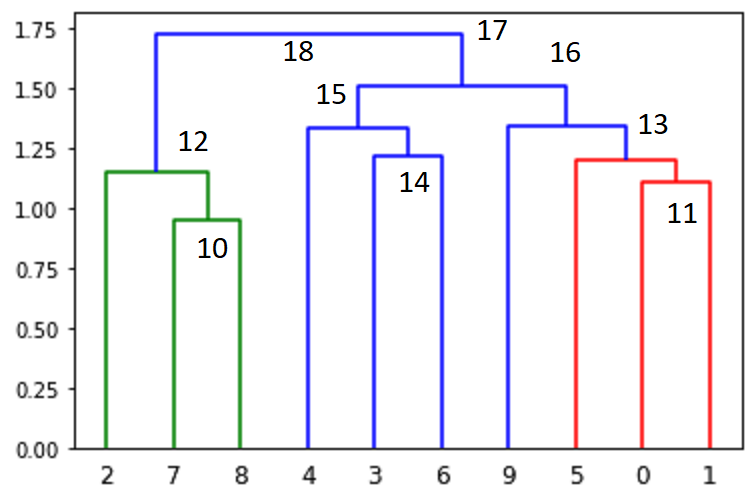  
 
 <a href='#toc'>TOC</a>

### Plot a dendrogram of agglomerative clusters of the first 30 beer reviews.

In [14]:
(X, vectorizer, review_instances) = get_beer_reviews_vectorized(30, (1, 2), 1000)

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram


def plot_beer_reviews():

    plt.figure(figsize=(10, 6))
    cls = ward(X.toarray())
    dendrogram(cls)
    plt.show()
    print(cls)

<a id='t3'></a>
### Task 3  (25 points)
Okay - here's what you need to do for this question. The goal is to compare how the large clusters found by hierarchical clustering compare with the ones you found using k-means clustering.

**Step 1.** Call `(X, vectorizer, review_instances) = get_beer_reviews_vectorized(1000, (1,2), 1000)` to get the review-term matrix of sparse vectors corresponding to the first 1000 reviews in the dataset (and using the top 1000 bigram terms by frequency).

**Step 2.** Use the scipy wards method to cluster the instances in X.

**Step 3.** Use the resulting hierarchical cluster tree to get the reviews that fall into each of K clusters, where K = 2.

The easiest way to do this question is to use the "fcluster" function that's part of the scipy.cluster.hierarchy package.
See https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html

You should use the 'maxclust' option of fcluster to automatically find the merge distance threshold that splits the reviews into K clusters and returns the cluster label of each review.  Use K = 2 for the results you submit.

**Step 4a** Write a loop that, for each cluster you found in Step 3, does the following:

**Step 4b**  Use the loop index 0, 1, ... as the cluster ID. Within the loop, filter the results of `fcluster` to find only the instances that belong to the given cluster ID.  Recall that the numpy "where" function can return you the indices of an array that meet your condition (such as which cluster index an instance has). You can then use these indices to select all elements with a given cluster ID.

**Step 4c.** Next within the loop, call the `compute_centroid` function to compute a centroid for the elements you found in Step 4b: the result will be a 'typical' review for that cluster -- essentially, a "term cloud" for that cluster's reviews. 

**Step 4d.** Next within the loop, find the top FIVE terms in the centroid having the *highest* weight (sorted by descending weight), and save the strings for those terms in a list.

**Step 5.** Outside the loop, your function should return a list that contains TWO term lists (strings) corresponding to the K=2 clusters. Each term list should contain the top *five* terms in the cluster centroid you computed (sorted by highest to lowest term weight).  

<a href='#toc'>TOC</a>

In [15]:
def compute_centroid(X, node_list):
    """New centroid calculation function!
    compute_centroid:  given X, a review-term matrix of sparse vectors generated by
    a vectorizer, and a list of row indices to extract from that matrix,
    return the centroid of the selected vectors.
    """

    cluster_instances = X[node_list, :]

    dense_cluster_instances = cluster_instances.todense()

    centroid = np.mean(dense_cluster_instances, axis=0)

    return centroid

In [16]:
# Too bad there is not a key to unlock this door.
task_id = "3"

In [17]:
def answer_hierarchy():
    result = []
    from scipy.cluster.hierarchy import linkage, fcluster, ward
    (X, vectorizer, review_instances) = get_beer_reviews_vectorized(1000, (1,2), 1000)
    Z = ward(X.toarray())
    cluster_id = fcluster(Z,2,criterion ='maxclust')-1
    terms = vectorizer.get_feature_names()
    l = []
    for k in range(0,2):
        # Get the indices of reviews in cluster k
        node_list = np.where(cluster_id == k)[0]
        # Compute the centroid of the cluster
        centroid = np.array(compute_centroid(X, node_list)).flatten()
#         top_5_indices = centroid.argsort()[::-1][:5]
        top_5_indices = np.argsort(centroid)[::-1][:5]
        top_5_terms = [terms[i] for i in top_5_indices]
        result.append(top_5_terms)
 

    return result

In [18]:
print(f"Task {task_id} - AG tests")
stu_ans = answer_hierarchy()

print(f"Task {task_id} - your answer:\n{stu_ans}")

assert isinstance(
    stu_ans, list
), "Q3: Your function should return a list (of string lists). "

assert np.array(
    [type(elt) == list for elt in stu_ans]
).all(), "Q3: each cluster summary should be a list (of terms)."

assert np.array(
    [len(elt) == 5 for elt in stu_ans]
).all(), "Q3: each cluster summary should have exactly 5 terms."

del stu_ans

Task 3 - AG tests
Task 3 - your answer:
[['pumpkin', 'pie', 'pumpkin pie', 'spices', 'nutmeg'], ['nice', 'light', 'sweet', 'hops', 'good']]


<a id='Topic4'></a>
## Topic 4 - Clustering, Feature Types, and Representations (25 points total).

### Clustering with mixed feature types and cluster representations.

The classic version of k-means assumes squared Euclidean distance. This assumption is used when the cluster representatives $m_k$ are assumed to be the means of the currently assigned cluster members. This is fine if all the features/variables are continuous values where taking the mean over them makes sense. However, there are many situations where we have a mixture of feature types, including categorical or ordinal features, where computing a mean doesn't make sense. In these cases, we must consider a more general version of k-means, based on an arbitrary dissimilarity function $D(x_i, x_j)$ between items that is used to compute the optimal cluster representatives $m_k$ (instead of a mean). One widely-used example of this is *k-medoids clustering*, which finds an existing item in the cluster that has minimum total distance to the other points in the cluster. (Even more generally, we can define a clustering algorithm just using proximity matrices of items, if they are available, and not even computing cluster centers: just keeping the item index of the cluster representative.)

We're going use k-medoids for this question - but scikit-learn doesn't yet have a k-medoids implementation, so we're going to use a package called sklearn-extra, which is installed for you in the unsupervised learning Coursera environment. Note that k-medoid is computationally expensive: a naive implementation is quadratic in its runtime requirements (in $n$, the number of data instances) although more clever implementations can reduce that.

Another problem this question deals with is how to do clustering when your data has a mix of feature types. We solve this here by computing a generalized form of distance between instances called the *Gower distance.*

Here's a summary of how Gower distance is computed:  For each variable type, pick a distance that scales 0 to 1, then take a linear combination of these distance based on user-specified weights.
 
For quantative (interval) variables: use manhattan distance.
For ordinal variables: rank or manhattan distances, with special adjustment for ties.
For nominal variables: variables of k categories are converted to one-hot encoding (k binary columns) and compared using the Dice coefficient.  You can read more about one-hot encodings in Chapter 4 of the course textbook (Intro to ML with Python), and the Dice coefficient here: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

 
For more details about the Gower distance, see: Gower, J.C., 1971, A General Coefficient of Similarity and Some of Its Properties. Biometrics.  Vol. 27, No. 4 (Dec., 1971), pp. 857-871.  

<a href='#toc'>TOC</a>

### We're going to work with the following dataset about U.S. colleges and universities. It contains statistics for a large number of US Colleges from the 1995 issue of US News and World Report.

A data frame with 777 observations on the following 18 variables:

`Private` A factor with levels No and Yes indicating private or public university

`Apps` Number of applications received

`Accept` Number of applications accepted

`Enroll` Number of new students enrolled

`Top10perc` Pct. new students from top 10% of H.S. class

`Top25perc` Pct. new students from top 25% of H.S. class

`F.Undergrad` Number of fulltime undergraduates

`P.Undergrad` Number of parttime undergraduates

`Outstate` Out-of-state tuition

`Room.Board` Room and board costs

`Books` Estimated book costs

`Personal` Estimated personal spending

`PhD` Pct. of faculty with Ph.D.’s

`Terminal` Pct. of faculty with terminal degree

`S.F.Ratio` Student/faculty ratio

`perc.alumni` Pct. alumni who donate

`Expend` Instructional expenditure per student

`Grad.Rate` Graduation rate  

### Be sure the following cell is executes to load the college dataset.

In [19]:
df = pd.read_csv("./assets/college.csv")
df = df.dropna()

### Use the following gower_distances() function to compute a Gower distance matrix.

In [20]:
from scipy.spatial import distance
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse

# The following functions are provided by Marcelo Beckmann and currently are part of the scikit-learn
# github repository but have not yet been officially released.

# This is a utility function used by gower_distances below.
def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    X, Y, dtype_float = pairwise._return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = "check_pairwise_arrays"
    if dtype is None:
        dtype = dtype_float

    if Y is X or Y is None:
        X = Y = validation.check_array(
            X, accept_sparse="csr", dtype=dtype, estimator=estimator
        )
    else:
        X = validation.check_array(
            X, accept_sparse="csr", dtype=dtype, estimator=estimator
        )
        Y = validation.check_array(
            Y, accept_sparse="csr", dtype=dtype, estimator=estimator
        )

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError(
                "Precomputed metric requires shape "
                "(n_queries, n_indexed). Got (%d, %d) "
                "for %d indexed." % (X.shape[0], X.shape[1], Y.shape[0])
            )
    elif X.shape[1] != Y.shape[1]:
        raise ValueError(
            "Incompatible dimension for X and Y matrices: "
            "X.shape[1] == %d while Y.shape[1] == %d" % (X.shape[1], Y.shape[1])
        )

    return X, Y


# gower_distances: see header below for details.
#
# For purposes of this assignment you can simply call it like this on a dataset X (n instances):
# D = gower_distances(X)
#
# which results an n x n distance matrix.
#
# Source: M. Beckmann  https://github.com/scikit-learn/scikit-learn/pull/9555


def gower_distances(X, Y=None, feature_weight=None, categorical_features=None):
    """Computes the gower distances between X and Y

    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.


    Parameters
    ----------
    X : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    Y : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    feature_weight :  array-like, shape (n_features)
        According the Gower formula, feature_weight is an attribute weight.

    categorical_features: array-like, shape (n_features)
        Indicates with True/False whether a column is a categorical attribute.
        This is useful when categorical atributes are represented as integer
        values. Categorical ordinal attributes are treated as numeric, and must
        be marked as false.

        Alternatively, the categorical_features array can be represented only
        with the numerical indexes of the categorical attribtes.

    Returns
    -------
    similarities : ndarray, shape (n_samples, n_samples)

    Notes
    ------
    The non-numeric features, and numeric feature ranges are determined from X and not Y.
    No support for sparse matrices.

    """

    if issparse(X) or issparse(Y):
        raise TypeError("Sparse matrices are not supported for gower distance")

    y_none = Y is None

    # It is necessary to convert to ndarray in advance to define the dtype
    if not isinstance(X, np.ndarray):
        X = np.asarray(X)

    # this is necessary as strangelly the validator is rejecting
    #  numeric arrays with NaN
    # array_type = np.object

    # array_type = object replaces above due to deprecation of
    # np.object.
    array_type = object

    if np.issubdtype(X.dtype, np.number) and (
        np.isfinite(X.sum()) or np.isfinite(X).all()
    ):
        array_type = type(np.zeros(1, X.dtype).flat[0])

    X, Y = check_pairwise_arrays(X, Y, precomputed=False, dtype=array_type)

    n_rows, n_cols = X.shape

    if categorical_features is None:
        categorical_features = np.zeros(n_cols, dtype=bool)
        for col in range(n_cols):
            # In numerical columns, None is converted to NaN,
            # and the type of NaN is recognized as a number subtype
            if not np.issubdtype(type(X[0, col]), np.number):
                categorical_features[col] = True
    else:
        categorical_features = np.array(categorical_features)

    # if categorical_features.dtype == np.int32:
    # np.int deprecated
    # if np.issubdtype(categorical_features.dtype, np.int):

    if np.issubdtype(categorical_features.dtype, np.int64):
        new_categorical_features = np.zeros(n_cols, dtype=bool)
        new_categorical_features[categorical_features] = True
        categorical_features = new_categorical_features

    # print(categorical_features)

    # Categorical columns
    X_cat = X[:, categorical_features]

    # Numerical columns
    X_num = X[:, np.logical_not(categorical_features)]
    ranges_of_numeric = None
    max_of_numeric = None

    # Calculates the normalized ranges and max values of numeric values
    _, num_cols = X_num.shape
    ranges_of_numeric = np.zeros(num_cols)
    max_of_numeric = np.zeros(num_cols)
    for col in range(num_cols):
        col_array = X_num[:, col].astype(np.float32)
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)

        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        max_of_numeric[col] = max
        ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    # This is to normalize the numeric values between 0 and 1.
    X_num = np.divide(
        X_num, max_of_numeric, out=np.zeros_like(X_num), where=max_of_numeric != 0
    )

    if feature_weight is None:
        feature_weight = np.ones(n_cols)

    feature_weight_cat = feature_weight[categorical_features]
    feature_weight_num = feature_weight[np.logical_not(categorical_features)]

    y_n_rows, _ = Y.shape

    dm = np.zeros((n_rows, y_n_rows), dtype=np.float32)

    feature_weight_sum = feature_weight.sum()

    Y_cat = None
    Y_num = None

    if not y_none:
        Y_cat = Y[:, categorical_features]
        Y_num = Y[:, np.logical_not(categorical_features)]
        # This is to normalize the numeric values between 0 and 1.
        Y_num = np.divide(
            Y_num, max_of_numeric, out=np.zeros_like(Y_num), where=max_of_numeric != 0
        )
    else:
        Y_cat = X_cat
        Y_num = X_num

    for i in range(n_rows):
        j_start = i

        # for non square results
        if n_rows != y_n_rows:
            j_start = 0

        Y_cat[j_start:n_rows, :]
        Y_num[j_start:n_rows, :]
        result = _gower_distance_row(
            X_cat[i, :],
            X_num[i, :],
            Y_cat[j_start:n_rows, :],
            Y_num[j_start:n_rows, :],
            feature_weight_cat,
            feature_weight_num,
            feature_weight_sum,
            categorical_features,
            ranges_of_numeric,
            max_of_numeric,
        )
        dm[i, j_start:] = result
        dm[i:, j_start] = result

    return dm


def _gower_distance_row(
    xi_cat,
    xi_num,
    xj_cat,
    xj_num,
    feature_weight_cat,
    feature_weight_num,
    feature_weight_sum,
    categorical_features,
    ranges_of_numeric,
    max_of_numeric,
):
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat, np.zeros_like(xi_cat), np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat, sij_cat).sum(axis=1)

    # numerical columns
    abs_delta = np.absolute(xi_num - xj_num)
    sij_num = np.divide(
        abs_delta,
        ranges_of_numeric,
        out=np.zeros_like(abs_delta),
        where=ranges_of_numeric != 0,
    )

    sum_num = np.multiply(feature_weight_num, sij_num).sum(axis=1)
    sums = np.add(sum_cat, sum_num)
    sum_sij = np.divide(sums, feature_weight_sum)
    return sum_sij

<a id='t4a'></a>
### Task 4a -  Using the Gower distances in the matrix D computed by the provided function, find the most and least similar pairs of colleges in the dataset (15 points).  

Note that an item is most similar to itself (distance = 0.) but you need to disallow this case since we actually care about finding two *distinct* items not along the diagonal that are most similar. One quick way to accomplish this is to replace the zeros along the diagonal of the distance matrix D returned by the gower_distances function, with a very large number (e.g. 1000) that wouldn't occur as a distance in practice.

You may also find numpy's `unravel_index` function, in combination with `argmax` or `argmin`, useful for finding min/max elements in an array. Remember that the least similar elements will have maximum distance from each other, and most similar will have minimum distance.

Your function should return a 2-element tuple, consisting itself of two tuples: the first tuple should be the names (via the College.Name field) of the two colleges that are *least* similar according the Gower distance. The second tuple should name the *most* similar colleges.  

<a href='#toc'>TOC</a>

In [21]:
task_id = "4a"

In [22]:
df.head()

,College.Name,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [23]:
def answer_mixed_features_a():
    result = None

    dis = gower_distances(df)

    # Replace diagonal elements with a large number to ignore self-similarity
    min_met = dis + np.diag(np.ones(dis.shape[0])*100)

    # Find indices of the most similar pair (minimum distance)
    min_pair, _ = np.where(min_met == np.min(min_met))
    
    # Find indices of the least similar pair (maximum distance)
    max_pair, _ = np.where(dis == np.max(dis))

    result = ((df['College.Name'][max_pair[0]],df['College.Name'][max_pair[1]]),\
     (df['College.Name'][min_pair[0]],df['College.Name'][min_pair[1]]))

    return result

In [24]:
print(f"Task {task_id} - AG tests")
stu_ans = answer_mixed_features_a()

print(f"Task {task_id} - your answer:\n{stu_ans}")

assert isinstance(stu_ans, tuple), "Task 4a: Your function should return a tuple. "
assert len(stu_ans) == 2, "Task 4a: Your return tuple should have 2 values. "

assert isinstance(stu_ans[0], tuple), "Task 4a: The first element should be a tuple. "
assert len(stu_ans[0]) == 2, "Task 4a: The first tuple should have 2 values. "

assert isinstance(stu_ans[1], tuple), "Task 4a: The second element should be a tuple. "
assert len(stu_ans[1]) == 2, "Task 4a: The second tuple should have 2 values. "

assert isinstance(stu_ans[0][0], str), "Task 4a: Element [0][0] must be a string."
assert isinstance(stu_ans[0][1], str), "Task : Element [0][0] must be a string."
assert isinstance(stu_ans[1][0], str), "Task 4a: Element [1][0] must be a string."
assert isinstance(stu_ans[1][1], str), "Task 4a: Element [1][1] must be a string."


del stu_ans

Task 4a - AG tests
Task 4a - your answer:
(('Center for Creative Studies', 'Texas A&M Univ. at College Station'), ('Augustana College IL', 'Hope College'))


<a id='t4b'></a>
### Task 4b - With the dissimilarity matrix you computed in Part A, now run k-medoids clustering with 3 clusters, and return the central representative found by k-medoids for each cluster (10 points).

Your function should return a dataframe with 3 rows corresponding to the k-medoids representatives for each cluster, and have columns named "College.Name", "Private", "Enroll","Expend", and "Grad.Rate" containing those values of the representative college.

NOTE: Call KMedoids using the metric = 'precomputed' option, and random_state = 42. Make sure your dataframe is ordered in the same order as the medoid indices that are returned by kmedoids.medoid_indices_.  

<a href='#toc'>TOC</a>

In [25]:
task_id = "4b"

In [26]:
def answer_mixedfeatures_b():
    result = None
    from sklearn_extra.cluster import KMedoids
    dis = gower_distances(df)
    kmedoids = KMedoids(n_clusters=3, metric='precomputed', random_state=42)
    kmedoids.fit(dis)
    medoid_indices = kmedoids.medoid_indices_
    result = df.iloc[medoid_indices][['College.Name','Private','Enroll','Expend','Grad.Rate']].reset_index(drop= True)

    return result

In [27]:
print(f"Task {task_id} - AG tests")
stu_ans = answer_mixedfeatures_b()

print(f"Task {task_id} - your answer:\n{stu_ans}")

assert isinstance(
    stu_ans, pd.DataFrame
), "Task 4b: Your function should return a pandas DataFrame. "
assert stu_ans.shape == (3, 5), "Task 4b: The shape of your dataframe isn't correct. "

assert list(stu_ans.columns) == [
    "College.Name",
    "Private",
    "Enroll",
    "Expend",
    "Grad.Rate",
], "Task 4b: Please check the column names of your DataFrame."

del stu_ans

Task 4b - AG tests
Task 4b - your answer:
                                 College.Name Private  Enroll  Expend  \
0                           Alfred University     Yes     472   10932   
1                      Westminster College MO     Yes     184    7925   
2  University of North Carolina at Wilmington      No    1449    6005   

   Grad.Rate  
0         73  
1         62  
2         55  


<a href='#toc'>TOC</a>